JS80P Waveshapers and Distortions
=================================

JS80P waveshapers use a technique called Antiderivative Antialiasing (ADAA). For the details see: [Reducing the Aliasing of Nonlinear Waveshaping Using Continuous-Time Convolution by Julian D. Parker, Vadim Zavalishin, Efflam Le Bivic](https://www.dafx.de/paper-archive/2016/dafxpapers/20-DAFx-16_paper_41-PN.pdf).

Wavefolder
----------

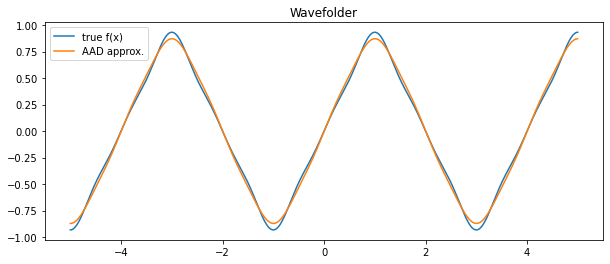

In [59]:
import math as m
import matplotlib.pyplot as plt


def plot_wavefolder():
    FOLD_MIN = 0.0
    FOLD_TRANSITION = 0.5
    FOLD_MAX = 5.0 + FOLD_TRANSITION

    PI = m.pi
    PI_DOUBLE = PI * 2.0
    PI_HALF = PI / 2.0
    PI_SQR = PI * PI

    TRIANGLE_SCALE = 8.0 / PI_SQR

    S0 = TRIANGLE_SCALE
    S1 = PI_HALF
    S2 = TRIANGLE_SCALE / 9.0
    S3 = PI_HALF * 3.0
    S4 = TRIANGLE_SCALE / 25.0
    S5 = PI_HALF * 5.0
    S6 = TRIANGLE_SCALE * 2.0 / PI
    S7 = TRIANGLE_SCALE / (27.0 * PI)
    S8 = TRIANGLE_SCALE / (125.0 * PI)

    TRIG_OFFSET = PI_DOUBLE * m.ceil(FOLD_MAX * S5)

    def f(x):
        return (
            S0 * m.sin(S1 * x + TRIG_OFFSET)
            - S2 * m.sin(S3 * x + TRIG_OFFSET)
            + S4 * m.sin(S5 * x + TRIG_OFFSET)
        )

    def F0(x):
        return (
            -S6 * m.cos(S1 * x + TRIG_OFFSET)
            + S7 * m.cos(S3 * x + TRIG_OFFSET)
            - S8 * m.cos(S5 * x + TRIG_OFFSET)
        )

    N = 2000
    folding = 5.0
    prev = -folding
    F0_prev = F0(prev)
    approximation = (F0(-folding + 1.0 / N) - F0(-folding)) * N

    xs = []
    fs = []
    approximations = []

    for i in range(N):
        x = (2.0 * (i / N)) - 1.0
        x = folding * x
        delta = x - prev

        xs.append(x)
        fs.append(f(x))

        if abs(delta) > 0.0:
            F0_x = F0(x)
            approximation = (F0_x - F0_prev) / delta
            approximations.append(approximation)
            F0_prev = F0_x
        else:
            approximations.append(approximation)

        prev = x

    plt.figure(figsize=(10, 4))
    plt.plot(xs, fs, label="true f(x)")
    plt.plot(xs, approximations, label="AAD approx.")
    plt.legend()
    plt.title("Wavefolder")
    plt.show()


plot_wavefolder()

Distortions
-----------

In [60]:
import math as m
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt


INPUT_MAX = 3.0
INPUT_MIN = - INPUT_MAX

PI2 = m.pi * 2.0


def tanh_f(x, steepness):
    return m.tanh(steepness * x * 0.5)


def tanh_F0(x, steepness, c):
    return x + (2.0 / steepness) * m.log1p(m.exp(-steepness * x)) + c


def join(alpha, gamma, h, dh, H):
    def combine_branches(funcs):
        return lambda x: (
            funcs[0](x) if x < gamma
                else (funcs[1](x) if x < 1.0 else funcs[2](x))
        )

    E = (alpha - 1.0) / 4.0
    cg = -9.0 * E

    g = lambda x: E * (x - 3.0) ** 2.0 + 1.0
    dg = lambda x: 2.0 * E * x - 6.0 * E
    G = lambda x: (((E / 3.0) * x - 3.0 * E) * x + 9.0 * E + 1.0) * x + cg

    L1 = gamma
    L2 = gamma ** 2.0
    L3 = gamma ** 3.0
    L4 = gamma ** 4.0

    eq_mtx = np.array(
        [
            [   3.0 * L2,   2.0 * L1,        1.0,         0.0,   0.0,     0.0],
            [         L3,         L2,         L1,         1.0,   0.0,     0.0],
            [   3.0 * L4,   4.0 * L3,   6.0 * L2,   12.0 * L1,  12.0,   -12.0],
            [        3.0,        2.0,        1.0,         0.0,   0.0,     0.0],
            [        1.0,        1.0,        1.0,         1.0,   0.0,     0.0],
            [        3.0,        4.0,        6.0,        12.0,  12.0,     0.0],
        ]
    )
    eq_v = np.array(
        [
                  dh(gamma),
                   h(gamma),
            12.0 * H(gamma),
                1.0 - alpha,
                      alpha,
                12.0 * G(1),
        ]
    )
    A, B, C, D, cf, ch = la.inv(eq_mtx).dot(eq_v)

    H_p_ch = lambda x: H(x) + ch

    f = lambda x: ((A * x + B) * x + C) * x + D
    df = lambda x: (3.0 * A * x + 2.0 * B) * x + C
    F = lambda x: ((((A / 4.0) * x + B / 3.0) * x + C / 2.0) * x + D) * x + cf

    return (
        (combine_branches((h, f, g)), combine_branches((H_p_ch, F, G))),
        (A, B, C, D, cf, ch)
    )


def bit_crush(type_const, k, alpha, gamma):
    PI2k = PI2 * k
    W = 1.0 / (1.4 * m.pi * k)

    h_k = lambda x: x - W * m.sin(PI2k * x)
    dh_k = lambda x: 1 - W * m.cos(PI2k * x)
    H_k = lambda x: x ** 2.0 / 2.0 + W * m.cos(PI2k * x) / PI2k

    funcs, (A, B, C, D, cf, ch) = join(alpha, gamma, h_k, dh_k, H_k)

    print(f"""\

    initialize_bit_crush_tables(
        {type_const},
        {k},
        {alpha},
        {gamma},
        {A},
        {B},
        {C},
        {D},
        {cf},
        {ch}
    );""")

    return alpha, gamma, funcs


def harmonics(type_const, alpha, gamma, w1, w3, w5, norm=1.0):
    w1 *= norm
    w3 *= norm
    w5 *= norm

    # Chebyshev polynomials and their derivatives and integrals
    t1 = lambda x: x
    t3 = lambda x: 4.0 * x ** 3.0 - 3.0 * x
    t5 = lambda x: 16.0 * x ** 5.0 - 20.0 * x ** 3.0 + 5.0 * x

    dt1 = lambda x: 1.0
    dt3 = lambda x: 12.0 * x ** 2.0 - 3.0
    dt5 = lambda x: 80.0 * x ** 4.0 - 60.0 * x ** 2.0 + 5.0

    T1 = lambda x: (1.0 / 2.0) * x ** 2.0
    T3 = lambda x: x ** 4.0 - (3.0 / 2.0) * x ** 2.0
    T5 = lambda x: (16.0 / 6.0) * x ** 6.0 - 5.0 * x ** 4.0 + (5.0 / 2.0) * x ** 2.0

    h = lambda x: w1 * t1(x) + w3 * t3(x) + w5 * t5(x)
    dh = lambda x: w1 * dt1(x) + w3 * dt3(x) + w5 * dt5(x)
    H = lambda x: w1 * T1(x) + w3 * T3(x) + w5 * T5(x)

    funcs, (A, B, C, D, cf, ch) = join(alpha, gamma, h, dh, H)

    print(f"""\

    initialize_harmonic_tables(
        {type_const},
        {w1},
        {w3},
        {w5},
        {alpha},
        {gamma},
        {A},
        {B},
        {C},
        {D},
        {cf},
        {ch}
    );""")

    return alpha, gamma, funcs


SQR = (
    4.0 / m.pi, 4.0 / (3.0 * m.pi),
    4.0 / (5.0 * m.pi),
)
TRI = (
    8.0 / (1.0 * m.pi) ** 2.0,
    -8.0 / (3.0 * m.pi) ** 2.0,
    8.0 / (5.0 * m.pi) ** 2.0,
)

TANH_F0_3_C = INPUT_MAX - tanh_F0(INPUT_MAX, 3.0, 0.0)
TANH_F0_5_C = INPUT_MAX - tanh_F0(INPUT_MAX, 5.0, 0.0)
TANH_F0_10_C = INPUT_MAX - tanh_F0(INPUT_MAX, 10.0, 0.0)

DISTORTIONS = (
    ("tanh(3x/2)",  (1.0, 1.0, (lambda x: tanh_f(x,  3.0), lambda x: tanh_F0(x,  3.0,  TANH_F0_3_C)))),
    ("tanh(5x/2)",  (1.0, 1.0, (lambda x: tanh_f(x,  5.0), lambda x: tanh_F0(x,  5.0,  TANH_F0_5_C)))),
    ("tanh(10x/2)", (1.0, 1.0, (lambda x: tanh_f(x, 10.0), lambda x: tanh_F0(x, 10.0, TANH_F0_10_C)))),

    ("harmonic 1+3", harmonics("TYPE_HARMONIC_13",    0.90, 0.80, 1.0, 1.0, 0.0, norm=1.10)),
    ("harmonic 1+5", harmonics("TYPE_HARMONIC_15",    0.90, 0.80, 1.0, 0.0, 1.0, norm=0.67)),
    ("harmonic 1+3+5", harmonics("TYPE_HARMONIC_135", 0.90, 0.80, 1.0, 1.0, 1.0, norm=1.20)),
    ("harmonic SQR", harmonics("TYPE_HARMONIC_SQR",   0.90, 0.80, *SQR, norm=1.10)),
    ("harmonic TRI", harmonics("TYPE_HARMONIC_TRI",   0.90, 0.80, *TRI, norm=1.20)),

    ("bit crush 1", bit_crush("TYPE_BIT_CRUSH_1",       1, 0.980, 0.720)),
    ("bit crush 2", bit_crush("TYPE_BIT_CRUSH_2",       2, 0.980, 0.630)),
    ("bit crush 3", bit_crush("TYPE_BIT_CRUSH_3",       4, 0.950, 0.810)),
    ("bit crush 4", bit_crush("TYPE_BIT_CRUSH_4",       8, 0.970, 0.903)),
    ("bit crush 4.6", bit_crush("TYPE_BIT_CRUSH_4_6",  12, 0.975, 0.936)),
    ("bit crush 5", bit_crush("TYPE_BIT_CRUSH_5",      16, 0.980, 0.953)),
    ("bit crush 5.6", bit_crush("TYPE_BIT_CRUSH_5_6",  24, 0.986, 0.968)),
    ("bit crush 6", bit_crush("TYPE_BIT_CRUSH_6",      32, 0.990, 0.976)),
    ("bit crush 6.6", bit_crush("TYPE_BIT_CRUSH_6_6",  48, 0.990, 0.984)),
    ("bit crush 7", bit_crush("TYPE_BIT_CRUSH_7",      64, 0.993, 0.988)),
    ("bit crush 7.6", bit_crush("TYPE_BIT_CRUSH_7_6",  96, 0.997, 0.992)),
    ("bit crush 8", bit_crush("TYPE_BIT_CRUSH_8",     128, 0.999, 0.994)),
    ("bit crush 8.6", bit_crush("TYPE_BIT_CRUSH_8_6", 192, 0.999, 0.993)),
    ("bit crush 9", bit_crush("TYPE_BIT_CRUSH_9",     256, 0.999, 0.995)),
)


def plot_distortion(dist_type):
    if not (0 <= dist_type < len(DISTORTIONS)):
        raise ValueError(
            f"Distortion type must be between 0 and {len(DISTORTIONS) - 1}, got: {dist_type}",
        )

    title, (alpha, gamma, (f_pos, F0_pos)) = DISTORTIONS[dist_type]

    f = lambda x: f_pos(x) if x >= 0.0 else -f_pos(-x)
    F0 = lambda x: F0_pos(x) if x >= 0.0 else F0_pos(-x)

    begin = -3.5
    end = 3.5
    range_ = end - begin
    N = 2000
    prev = begin
    F0_prev = F0(prev)

    xs = []
    fs = []
    F0s = []
    guide = []
    approximations = []
    F0_x = 0.0
    f_x = 0.0
    M = 0.0
    gM = 0.0

    for i in range(N):
        x = begin + range_ * (i / N)
        delta = x - prev

        if x < INPUT_MIN:
            F0_x = -x
            f_x = -1.0
        elif x >= INPUT_MAX:
            F0_x = x
            f_x = 1.0
        else:
            F0_x = F0(x)
            f_x = f(x)

        abs_f_x = abs(f_x)

        if abs_f_x > gM:
            gM = abs_f_x

        if x < -1.0:
            guide.append(-1.0)
        elif x > 1.0:
            guide.append(1.0)
        else:
            if 0 <= x <= gamma and abs_f_x > M:
                M = abs_f_x

            guide.append(x)

        xs.append(x)
        fs.append(f_x)
        F0s.append(F0_x)

        if abs(x - INPUT_MIN) < 0.0000001:
            approximations.append(-1.0)
        elif abs(x - INPUT_MAX) < 0.0000001:
            approximations.append(1.0)
        elif abs(delta) > 0.00000001:
            approximations.append((F0_x - F0_prev) / delta)
        else:
            approximations.append(f_x)

        prev = x
        F0_prev = F0_x

    print(f"global_max={gM}")
    print(f"max={M}")
    print(f"norm={1.0 / M}")
    print(f"norm_alpha={alpha / M}")

    plt.figure(figsize=(10, 5))
    plt.plot(xs, guide, label="guide")
    plt.plot(xs, fs, label="true f(x)")
    plt.plot(xs, approximations, label="AAD approx.")
    plt.plot(xs, F0s, label="F0(x)")
    plt.title(f"Distortion {title}")
    plt.legend()
    plt.show()


    initialize_harmonic_tables(
        TYPE_HARMONIC_13,
        1.1,
        1.1,
        0.0,
        0.9,
        0.8,
        56.89999999999904,
        -168.99999999999977,
        167.39999999999952,
        -54.39999999999995,
        13.874999999999957,
        1.1603333333333254
    );

    initialize_harmonic_tables(
        TYPE_HARMONIC_15,
        0.67,
        0.0,
        0.67,
        0.9,
        0.8,
        -249.35359999999906,
        672.888319999996,
        -597.6158399999965,
        174.9811199999989,
        -37.064239999999714,
        0.606781226666696
    );

    initialize_harmonic_tables(
        TYPE_HARMONIC_135,
        1.2,
        1.2,
        1.2,
        0.9,
        0.8,
        -235.79599999999957,
        621.7551999999969,
        -536.0223999999973,
        150.96319999999906,
        -30.18806666666643,
        0.9979216000000265
    );

    initialize_harmonic_tables(
        TYPE_HARMONIC_SQR,
        1.400563499208679,
        0.46685449

### tanh(3x/2)

global_max=1.0
max=0.9044682989619606
norm=1.1056219451225424
norm_alpha=1.1056219451225424


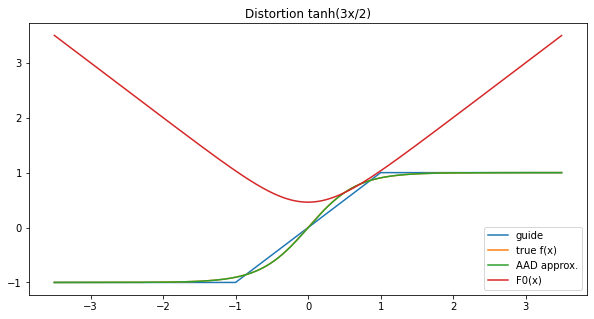

In [61]:
plot_distortion(0)

### tanh(5x/2)

global_max=1.0
max=0.9864470677124961
norm=1.0137391378930571
norm_alpha=1.0137391378930571


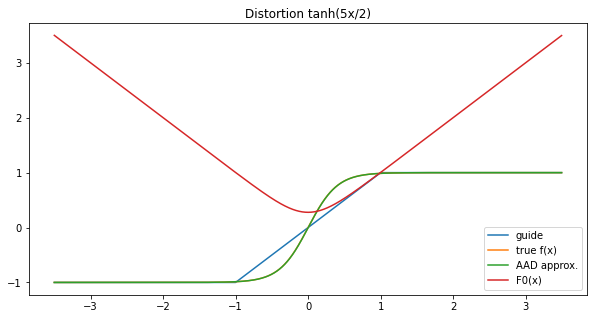

In [62]:
plot_distortion(1)

### tanh(10x/2)

global_max=1.0
max=0.9999069058645483
norm=1.0000931028027766
norm_alpha=1.0000931028027766


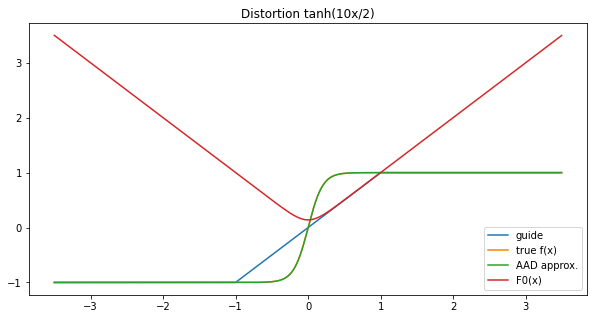

In [63]:
plot_distortion(2)

### harmonic 1+3

global_max=1.0
max=0.5987557075500001
norm=1.6701302173666435
norm_alpha=1.5031171956299791


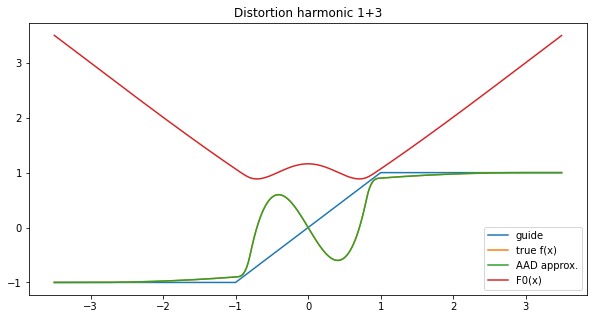

In [64]:
plot_distortion(3)

### harmonic 1+5

global_max=1.0
max=0.889015525586589
norm=1.1248397482599433
norm_alpha=1.012355773433949


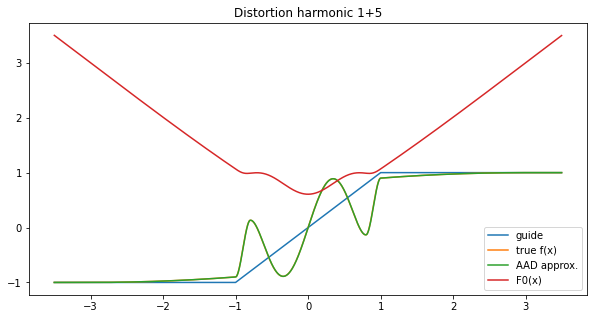

In [65]:
plot_distortion(4)

### harmonic 1+3+5

global_max=1.0
max=0.861033574917734
norm=1.16139489693598
norm_alpha=1.0452554072423819


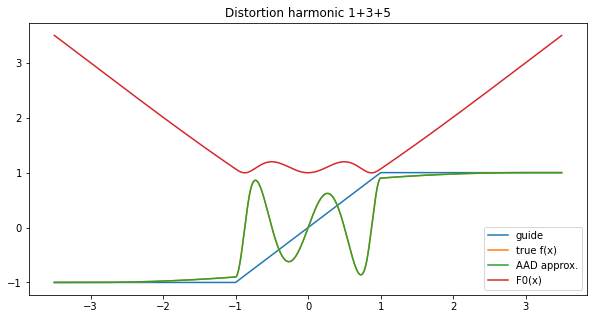

In [66]:
plot_distortion(5)

### harmonic SQR

global_max=1.0
max=0.6700509511312118
norm=1.4924238198778057
norm_alpha=1.343181437890025


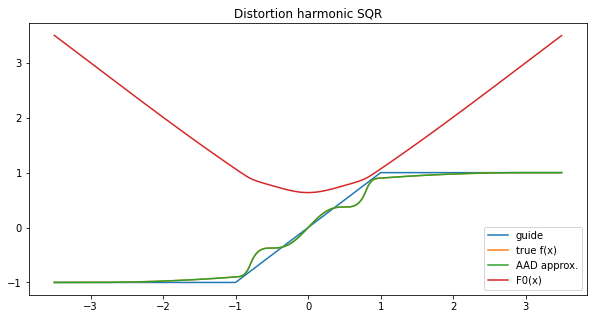

In [67]:
plot_distortion(6)

### harmonic TRI

global_max=1.0
max=0.7765106455872052
norm=1.287812350909613
norm_alpha=1.1590311158186517


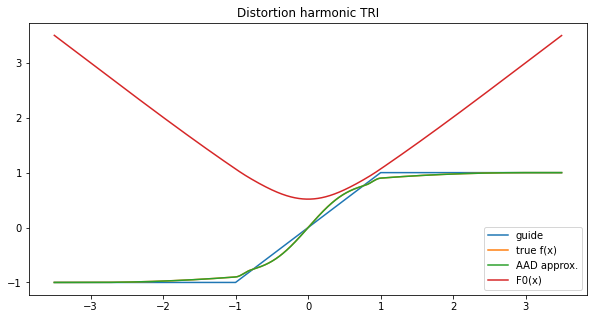

In [68]:
plot_distortion(7)

### bit crush 1

global_max=1.0
max=0.9401402152839902
norm=1.0636711245225563
norm_alpha=1.0423977020321051


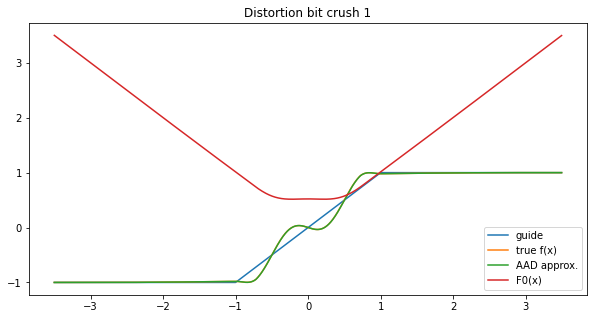

In [69]:
plot_distortion(8)

### bit crush 2

global_max=1.0
max=0.5178853853711702
norm=1.930929175155805
norm_alpha=1.892310591652689


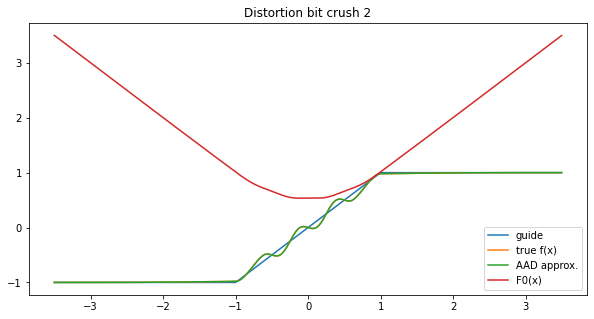

In [70]:
plot_distortion(9)

### bit crush 3

global_max=1.0
max=0.7589353430046544
norm=1.3176353021602094
norm_alpha=1.251753537052199


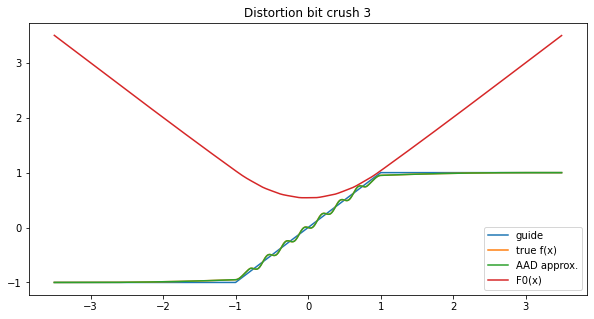

In [71]:
plot_distortion(10)

### bit crush 4

global_max=1.0
max=0.8793983913045593
norm=1.1371410385644805
norm_alpha=1.103026807407546


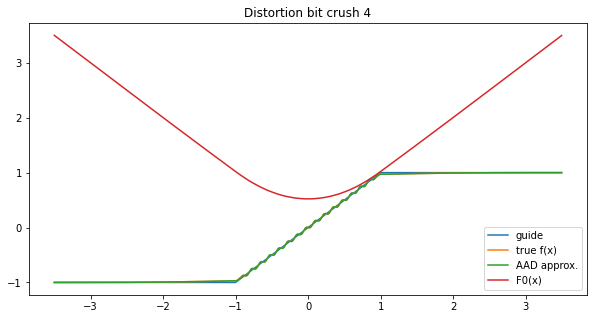

In [72]:
plot_distortion(11)

### bit crush 4.6

global_max=1.0
max=0.9196426610014454
norm=1.087378872692845
norm_alpha=1.060194400875524


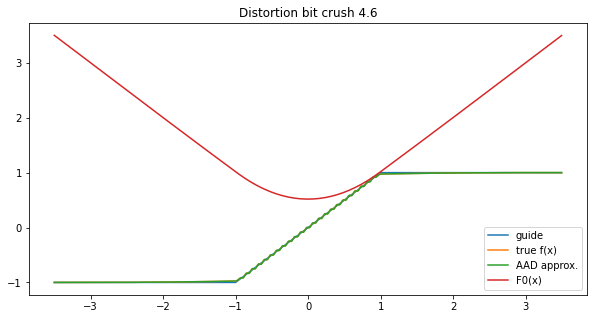

In [73]:
plot_distortion(12)

### bit crush 5

global_max=1.0
max=0.93963884927977
norm=1.0642386708111278
norm_alpha=1.042953897394905


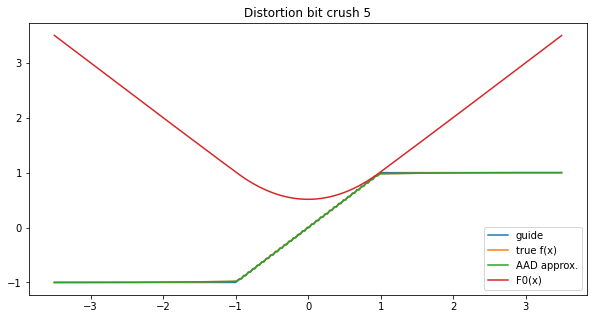

In [74]:
plot_distortion(13)

### bit crush 5.6

global_max=1.0
max=0.9597335968447366
norm=1.0419558128293571
norm_alpha=1.027368431449746


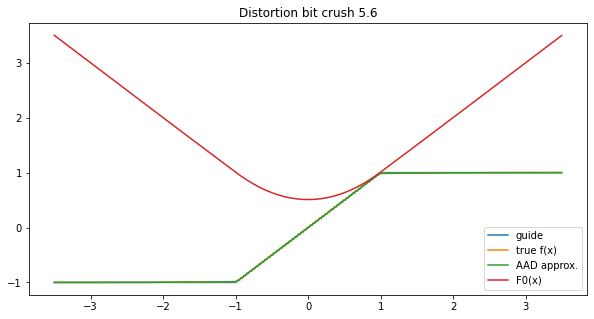

In [75]:
plot_distortion(14)

### bit crush 6

global_max=1.0
max=0.9697314347475356
norm=1.0312133485291675
norm_alpha=1.0209012150438757


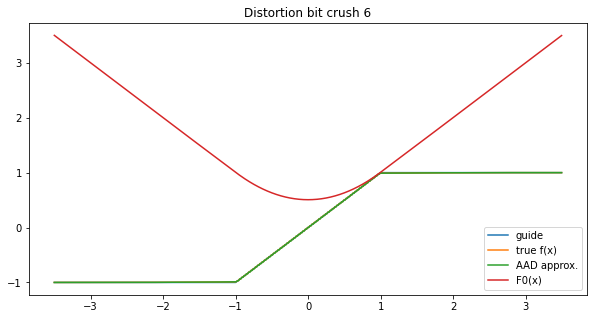

In [76]:
plot_distortion(15)

### bit crush 6.6

global_max=1.0
max=0.9799119268412088
norm=1.0204998761710617
norm_alpha=1.010294877409351


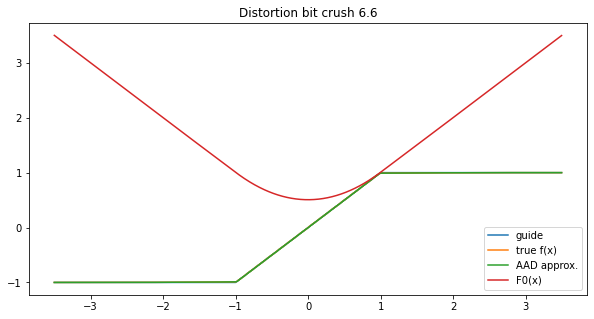

In [77]:
plot_distortion(16)

### bit crush 7

global_max=1.0
max=0.9847243666255553
norm=1.0155125981362594
norm_alpha=1.0084040099493055


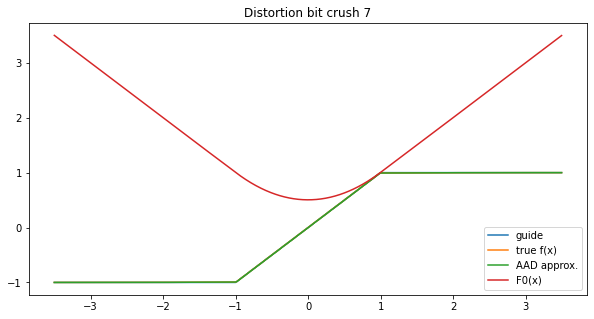

In [78]:
plot_distortion(17)

### bit crush 7.6

global_max=1.0
max=0.9893681901322419
norm=1.0107460599338018
norm_alpha=1.0077138217540005


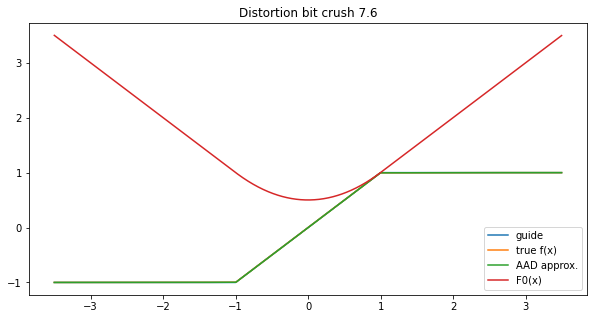

In [79]:
plot_distortion(18)

### bit crush 8

global_max=1.0
max=0.9922359046048216
norm=1.0078248482635495
norm_alpha=1.0068170234152858


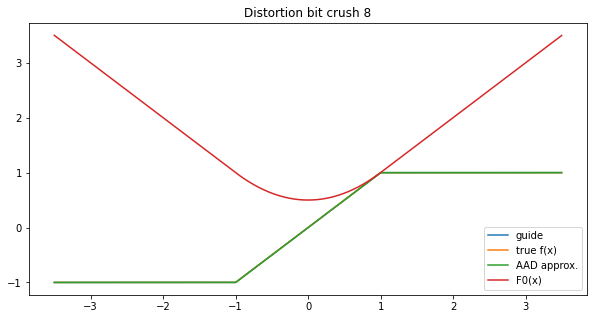

In [80]:
plot_distortion(19)

### bit crush 8.6

global_max=1.0
max=0.98944152320689
norm=1.0106711478601471
norm_alpha=1.009660476712287


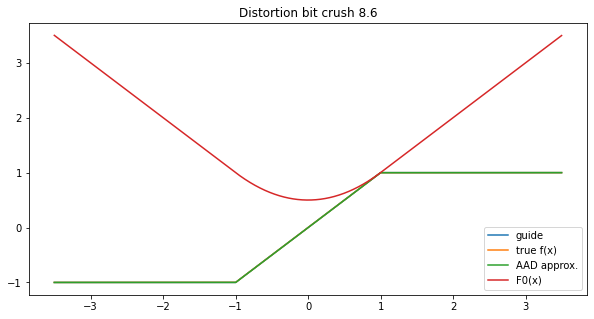

In [81]:
plot_distortion(20)

### bit crush 9

global_max=1.0
max=0.9938008158471195
norm=1.0062378537570391
norm_alpha=1.0052316159032821


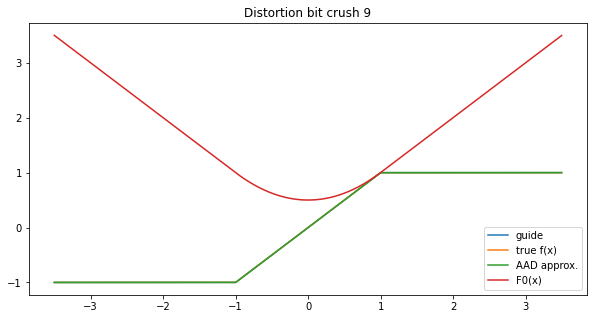

In [82]:
plot_distortion(21)

### Reduce

This is a soft-clipping distortion which ensures that the output
volume is always at least slightly lower than the input volume,
making it ideal for delays with feedback. For the details, see
`Distortion::Tables::initialize_delay_feedback_tables()`.


min_d = 0.0005347919445001237

alpha = 0.8779296875
beta = 0.625
gamma = 0.0625

cg = 0.274658203125

constexpr Number A = -1.186148148148148;
constexpr Number B = 1.6221944444444443;
constexpr Number C = 0.43612586805555564;
constexpr Number D = 0.005757523148148036;
constexpr Number cf = 0.6133653067129632;
constexpr Number ch = 0.6134837468465169;




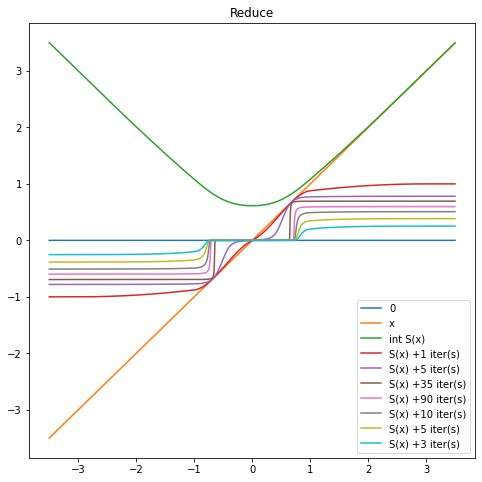

In [83]:
import math as m
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt


# The spline will be linear on the [0, gamma] interval.
gamma = 1.0 / 16.0

# Parameter: f'(gamma) := beta
beta = 5.0 / 8.0

# Parameter: f(1) = alpha
alpha = 899.0 / 1024.0


alpha_m_1_o_4 = (alpha - 1.0) / 4.0


# These will be set by solve_spline()
A = B = C = D = cf = ch = 0.0

cg = -9.0 * alpha_m_1_o_4


h = lambda x: beta * x
H = lambda x: (1.0 / 2.0) * beta * x ** 2.0 + ch


f = lambda x: ((A * x + B) * x + C) * x + D
F = lambda x: ((((A / 4.0) * x + (B / 3.0)) * x + (C / 2.0)) * x + D) * x + cf


g = lambda x: (
    (alpha_m_1_o_4 * x - 6.0 * alpha_m_1_o_4) * x + 9.0 * alpha_m_1_o_4 + 1.0
)
G = lambda x: (
    (
        ((alpha_m_1_o_4 / 3.0) * x - 3.0 * alpha_m_1_o_4) * x
        + 9.0 * alpha_m_1_o_4 + 1.0
    ) * x + cg
)


INPUT_MAX = 3.0


def solve_spline():
    global A, B, C, D, cf, ch

    A1 = 3.0 * gamma ** 4.0
    B1 = 4.0 * gamma ** 3.0
    C1 = 6.0 * gamma ** 2.0
    D1 = 12.0 * gamma

    A5 = 3.0 * gamma ** 2.0
    B5 = 2.0 * gamma

    A6 = gamma ** 3.0 - 1.0
    B6 = gamma ** 2.0 - 1.0
    C6 = gamma - 1.0

    eq_mtx = np.array(
        [
            [-12.0,  12.0,    D1,    A1,    B1,    C1],
            [  0.0,  12.0,  12.0,   3.0,   4.0,   6.0],
            [  0.0,   0.0,   1.0,   1.0,   1.0,   1.0],
            [  0.0,   0.0,   0.0,   3.0,   2.0,   1.0],
            [  0.0,   0.0,   0.0,    A5,    B5,   1.0],
            [  0.0,   0.0,   0.0,    A6,    B6,    C6],
        ]
    )
    eq_v = np.array(
        [
            6.0 * beta * gamma ** 2.0,
            20.0 - 8.0 * alpha,
            alpha,
            1.0 - alpha,
            beta,
            beta * gamma - alpha,
        ]
    )
    ch, cf, D, A, B, C = la.inv(eq_mtx).dot(eq_v)


def spline(x):
    sgn = 1.0

    if x < 0.0:
        sgn = -1.0
        x = -x

    if x >= INPUT_MAX:
        return sgn

    if x >= 1.0:
        return sgn * g(x)

    if x >= gamma:
        return sgn * f(x)

    return sgn * h(x)


def spline_int(x):
    if x < 0.0:
        x = -x

    if x >= INPUT_MAX:
        return x

    if x >= 1.0:
        return G(x)

    if x >= gamma:
        return F(x)

    return H(x)


def plot_reduce_dist():
    N = 2000
    width = 3.5

    solve_spline()

    funcs = (
        ("0", lambda x: 0, (([], 1),)),
        ("x", lambda x: x, (([], 1),)),
        ("int S(x)", lambda x: spline_int(x), (([], 1),)),
        (
            "S(x) +{} iter(s)",
            lambda x: spline(x),
            (([], 1), ([], 5), ([], 35), ([], 90), ([], 10), ([], 5), ([], 3)),
        ),
    )

    xs = []

    min_d = 999.0

    for i in range(N):
        x = (2.0 * (i / N)) - 1.0
        x = width * x

        if x > 0.0:
            s = spline(x)
            d = x - s

            if d < min_d:
                min_d = d

        xs.append(x)

        for label_tpl, f, iters in funcs:
            fx = x

            for values, n in iters:
                for i in range(n):
                    fx = f(fx)

                values.append(fx)

    values = [
        (label_tpl.format(n), v)
        for label_tpl, f, iters in funcs
        for v, n in iters
    ]

    print(f"""
min_d = {min_d}

alpha = {alpha}
beta = {beta}
gamma = {gamma}

cg = {cg}

constexpr Number A = {A};
constexpr Number B = {B};
constexpr Number C = {C};
constexpr Number D = {D};
constexpr Number cf = {cf};
constexpr Number ch = {ch};

""")

    plt.figure(figsize=(8, 8))

    for label, v in values:
        plt.plot(xs, v, label=label)

    plt.title("Reduce")
    plt.legend()
    plt.show()


plot_reduce_dist()

Envelope Shapes
---------------

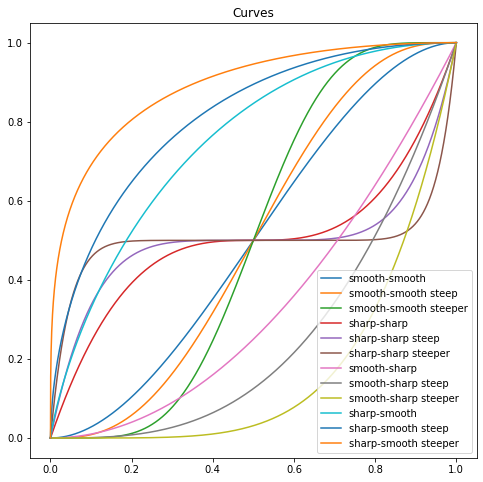

In [84]:
import math as m
import matplotlib.pyplot as plt


def smooth_smooth_steeper(x):
    a = -252.0
    b = 1386.0
    c = 3080.0
    d = 3465.0
    e = 1980.0
    f = 462.0

    return ((((((((((a * x + b) * x - c) * x + d) * x - e) * x + f) * x) * x) * x) * x) * x) * x


def sharp_sharp_steeper(x):
    a = 1024.0
    b = 5632.0
    c = 14080.0
    d = 21120.0
    e = 21120.0
    f = 14784.0
    g = 7392.0
    h = 2640.0
    i = 660.0
    j = 110.0
    k = 11.0

    return ((((((((((a * x - b) * x + c) * x - d) * x + e) * x - f) * x + g) * x - h) * x + i) * x - j) * x + k) * x


def plot_curves():
    curves = (
        ("smooth-smooth",         lambda x: ((-2.0 * x + 3.0) * x) * x),
        ("smooth-smooth steep",   lambda x: ((((6.0 * x - 15.0) * x + 10.0) * x) * x) * x),
        ("smooth-smooth steeper", smooth_smooth_steeper),
        ("sharp-sharp",           lambda x: ((4.0 * x - 6.0) * x + 3.0) * x),
        ("sharp-sharp steep",     lambda x: ((((16.0 * x - 40.0) * x + 40.0) * x - 20.0) * x + 5.0) * x),
        ("sharp-sharp steeper",   sharp_sharp_steeper),
        ("smooth-sharp",          lambda x: x ** 2.0),
        ("smooth-sharp steep",    lambda x: x ** 3.0),
        ("smooth-sharp steeper",  lambda x: x ** 5.0),
        ("sharp-smooth",          lambda x: x * (1.0 - m.log(x + 0.001)) / (1.0 - m.log(1.001))),
        ("sharp-smooth steep",    lambda x: (x * (1.0 - m.log(x + 0.001)) / (1.0 - m.log(1.001))) ** (2.0 / 3.0)),
        ("sharp-smooth steeper",  lambda x: (x * (1.0 - m.log(x + 0.001)) / (1.0 - m.log(1.001))) ** (1.0 / 3.0)),
    )

    N = 2000
    xs = [i / N for i in range(N + 1)]

    plt.figure(figsize=(8, 8))
    
    for name, f in curves:
        fxs = [f(x) for x in xs]
        plt.plot(xs, fxs, label=name)
    
    plt.title("Curves")
    plt.legend()
    plt.show()


plot_curves()

License
-------

    This file is part of JS80P, a synthesizer plugin.
    Copyright (C) 2023, 2024  Attila M. Magyar

    JS80P is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    JS80P is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.